<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Instacart Recommender: Recommendation for Groceries

---

# Premise

As a data analyst at Instacart, we are tasked to find out what is the likely next item to be bought by Instacart users. 

Our metrics will be based on an F1-score, based on a space-delimited list that we will submit to Kaggle (our company hosted this competition), and compared with an unknown test set.



(This was originated from a kaggle competition) 
https://www.kaggle.com/competitions/instacart-market-basket-analysis

## Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import operator
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

Creating a downcasting loop which allows for the dtypes to be reduced, as an attempt to solve memory issues

In [2]:
## downcasting loop
def downcasting(df):
    for column in df:
        if df[column].dtype == 'float64':
            df[column]=pd.to_numeric(df[column], downcast='float')
        elif df[column].dtype == 'int64':
            df[column]=pd.to_numeric(df[column], downcast='integer')
    ## dropping an unused column


## Reading in of all datas, and downcasting them

In [3]:
aisles = pd.read_csv("./all/aisles.csv")

In [4]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [6]:
downcasting(aisles)

In [7]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int16 
 1   aisle     134 non-null    object
dtypes: int16(1), object(1)
memory usage: 1.4+ KB


In [8]:
depart = pd.read_csv("./all/departments.csv")

In [9]:
depart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [10]:
downcasting(depart)

In [11]:
depart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int8  
 1   department     21 non-null     object
dtypes: int8(1), object(1)
memory usage: 317.0+ bytes


In [12]:
prior = pd.read_csv("./all/order_products__prior.csv")

In [13]:
prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [14]:
downcasting(prior)

In [15]:
prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int32
 1   product_id         int32
 2   add_to_cart_order  int16
 3   reordered          int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 340.3 MB


In [16]:
train = pd.read_csv("./all/order_products__train.csv")

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [18]:
downcasting(train)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int32
 1   product_id         1384617 non-null  int32
 2   add_to_cart_order  1384617 non-null  int8 
 3   reordered          1384617 non-null  int8 
dtypes: int32(2), int8(2)
memory usage: 13.2 MB


In [20]:
orders = pd.read_csv("./all/orders.csv")

In [21]:
downcasting(orders)

In [22]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int32  
 1   user_id                 int32  
 2   eval_set                object 
 3   order_number            int8   
 4   order_dow               int8   
 5   order_hour_of_day       int8   
 6   days_since_prior_order  float32
dtypes: float32(1), int32(2), int8(3), object(1)
memory usage: 75.0+ MB


In [23]:
products = pd.read_csv("./all/products.csv")

In [24]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [25]:
downcasting(products)

In [26]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int32 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int16 
 3   department_id  49688 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.0+ KB


In [27]:
sample = pd.read_csv("./all/sample_submission.csv")

In [28]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  75000 non-null  int64 
 1   products  75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [29]:
downcasting(sample)

In [30]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  75000 non-null  int32 
 1   products  75000 non-null  object
dtypes: int32(1), object(1)
memory usage: 879.0+ KB


# Simple EDA
Mainly to check for any missing values and a general idea of what is in the each dataset.

### Aisles

In [31]:
aisles.columns

Index(['aisle_id', 'aisle'], dtype='object')

In [32]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int16 
 1   aisle     134 non-null    object
dtypes: int16(1), object(1)
memory usage: 1.4+ KB


In [33]:
aisles.head(15)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [34]:
aisles.value_counts()

aisle_id  aisle                     
1         prepared soups salads         1
85        food storage                  1
99        canned fruit applesauce       1
98        juice nectars                 1
97        baking supplies decor         1
                                       ..
40        dog food care                 1
39        seafood counter               1
38        frozen meals                  1
37        ice cream ice                 1
134       specialty wines champagnes    1
Length: 134, dtype: int64

In [35]:
aisles.isnull().sum()

aisle_id    0
aisle       0
dtype: int64

In [36]:
aisles["aisle"].duplicated().any()

False

There are 134 unique values of types of aisles in Instacart.

### Department

In [37]:
depart.columns

Index(['department_id', 'department'], dtype='object')

In [38]:
depart.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [39]:
depart.describe()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


In [40]:
depart.isnull().sum()

department_id    0
department       0
dtype: int64

In [41]:
depart["department"].duplicated().any()

False

There are 21 unique values of departments.

### Products

In [42]:
products.columns

Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')

In [43]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [44]:
products.isnull().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [45]:
products["product_name"].duplicated().any()

False

In [46]:
products["aisle_id"].duplicated().any()

True

In [47]:
products["department_id"].duplicated().any()

True

It is understandable that there are duplicated aisle_id and department_id as there are multiple products from particular aisles, and particular types of food or items which are departments.

## Merging above columns
These columns will be more useful they are seen together.

In [48]:
prod_description = pd.merge(aisles,products)

In [49]:
prod_description

,aisle_id,aisle,product_id,product_name,department_id
0,1,prepared soups salads,209,Italian Pasta Salad,20
1,1,prepared soups salads,554,Turkey Chili,20
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20
4,1,prepared soups salads,2539,Original Potato Salad,20
...,...,...,...,...,...
49683,134,specialty wines champagnes,47713,Sparkling Rose,5
49684,134,specialty wines champagnes,48984,Dry Sherry,5
49685,134,specialty wines champagnes,49438,Dry Fino Sherry,5
49686,134,specialty wines champagnes,49562,Blanc De Noirs Sparkling Wine,5


In [50]:
prod_description = pd.merge(prod_description.copy(),depart)

In [51]:
depart['department']

0              frozen
1               other
2              bakery
3             produce
4             alcohol
5       international
6           beverages
7                pets
8     dry goods pasta
9                bulk
10      personal care
11       meat seafood
12             pantry
13          breakfast
14       canned goods
15         dairy eggs
16          household
17             babies
18             snacks
19               deli
20            missing
Name: department, dtype: object

In [52]:
prod_description 

,aisle_id,aisle,product_id,product_name,department_id,department
0,1,prepared soups salads,209,Italian Pasta Salad,20,deli
1,1,prepared soups salads,554,Turkey Chili,20,deli
2,1,prepared soups salads,886,Whole Grain Salad with Roasted Pecans & Mango ...,20,deli
3,1,prepared soups salads,1600,Mediterranean Orzo Salad,20,deli
4,1,prepared soups salads,2539,Original Potato Salad,20,deli
...,...,...,...,...,...,...
49683,100,missing,49553,Organic Plain Skyr,21,missing
49684,100,missing,49575,Chocolate Vanilla Malt Custard,21,missing
49685,100,missing,49641,"8\"" Pecan Pie",21,missing
49686,100,missing,49664,Lemon Cayenne Drinking Vinegar,21,missing


In [53]:
products = prod_description.drop(columns =['product_id','department_id'])

In [54]:
products

,aisle_id,aisle,product_name,department
0,1,prepared soups salads,Italian Pasta Salad,deli
1,1,prepared soups salads,Turkey Chili,deli
2,1,prepared soups salads,Whole Grain Salad with Roasted Pecans & Mango ...,deli
3,1,prepared soups salads,Mediterranean Orzo Salad,deli
4,1,prepared soups salads,Original Potato Salad,deli
...,...,...,...,...
49683,100,missing,Organic Plain Skyr,missing
49684,100,missing,Chocolate Vanilla Malt Custard,missing
49685,100,missing,"8\"" Pecan Pie",missing
49686,100,missing,Lemon Cayenne Drinking Vinegar,missing


In [55]:
prod_description[prod_description["product_id"] == 1]

,aisle_id,aisle,product_id,product_name,department_id,department
7689,61,cookies cakes,1,Chocolate Sandwich Cookies,19,snacks


In [56]:
prod_description[prod_description["product_id"] == 49683]

,aisle_id,aisle,product_id,product_name,department_id,department
31951,83,fresh vegetables,49683,Cucumber Kirby,4,produce


### Prior

In [57]:
prior.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [58]:
prior.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


In [59]:
prior.isnull().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [60]:
prior_new = pd.merge(prod_description,prior)

In [61]:
prior_new = prior_new.sort_values("order_id")

In [62]:
prior_new

,aisle_id,aisle,product_id,product_name,department_id,department,order_id,add_to_cart_order,reordered
11709114,104,spices seasonings,9327,Garlic Powder,13,pantry,2,3,0
11264861,88,spreads,1819,All Natural No Stir Creamy Almond Butter,13,pantry,2,8,1
21327903,83,fresh vegetables,28985,Michigan Organic Kale,4,produce,2,2,1
20426352,83,fresh vegetables,17794,Carrots,4,produce,2,6,1
10835025,19,oils vinegars,45918,Coconut Butter,13,pantry,2,4,1
...,...,...,...,...,...,...,...,...,...
6495066,3,energy granola bars,5020,Organic Sweet & Salty Peanut Pretzel Granola ...,19,snacks,3421083,10,1
17572275,24,fresh fruits,24852,Banana,4,produce,3421083,9,1
31248506,92,baby food formula,45309,Purple Carrot & blueberry Puffs,18,babies,3421083,2,0
9069446,117,nuts seeds dried fruit,7854,Freeze Dried Mango Slices,19,snacks,3421083,1,0


## Orders

In [63]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [64]:
total = orders.isnull().sum()
total

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [65]:
#to get a percentage of the total number of nulls
percentage=total/orders.isnull().count()
percentage

order_id                  0.000000
user_id                   0.000000
eval_set                  0.000000
order_number              0.000000
order_dow                 0.000000
order_hour_of_day         0.000000
days_since_prior_order    0.060276
dtype: float64

These null values correspond to first order of each customer- they still contain valuable information on each customer's buying habits.
We decide to keep the columns first, and will only remove them thereafter if we decide that this information is important.


In [66]:
df_1 = orders[orders["eval_set"]== "prior"]

In [67]:
df_1 = df_1.sort_values("order_id")

In [68]:
df_1

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
370620,6,22352,prior,4,1,12,30.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


In [69]:
df_2 = df_1.merge(prior_new,how='left', left_on='order_id', right_on='order_id')

In [70]:
df.sort_values(by=['order_id','add_to_cart_order'])

NameError: name 'df' is not defined

In [ ]:
df_3 = df_2.sort_values(by=["user_id","order_number"])

In [ ]:
df_3.to_csv('./data/df3.csv')

## Read in DF3

In [ ]:
df3 = pd.read_csv("./data/df3.csv")

In [ ]:
downcasting(df3)

# EDA

#### Counting the number of test, prior and train sets 

C:\Users\Asus\anaconda3\envs\dsi\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


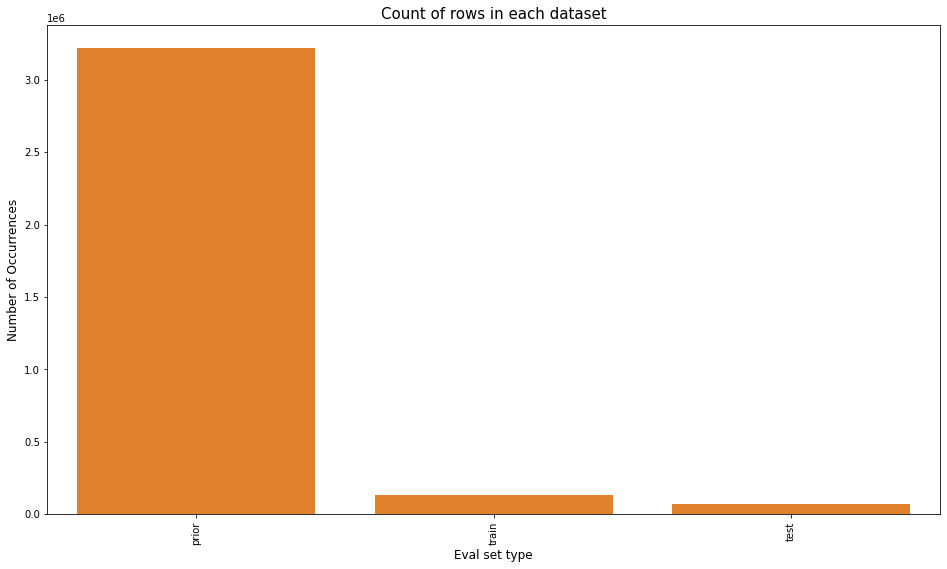

In [73]:
counts = orders.eval_set.value_counts()

plt.figure(figsize=(16,9))
sns.barplot(counts.index, counts.values, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [74]:
def get_unique_count(x):
    return len(np.unique(x))

counts = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)
counts

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

We see from the sum of test and train that it gives us exactly the value of prior. 

Further investigation shows that the last purcase of some customers are test, which the last purchase of some customers are in train. Therefore, there are 206,209 customers in total, of which, the last purchase of 131,209 customers are given as train set, and we need to predict for 75,000 customers.


## Orders by time of week and hour of day

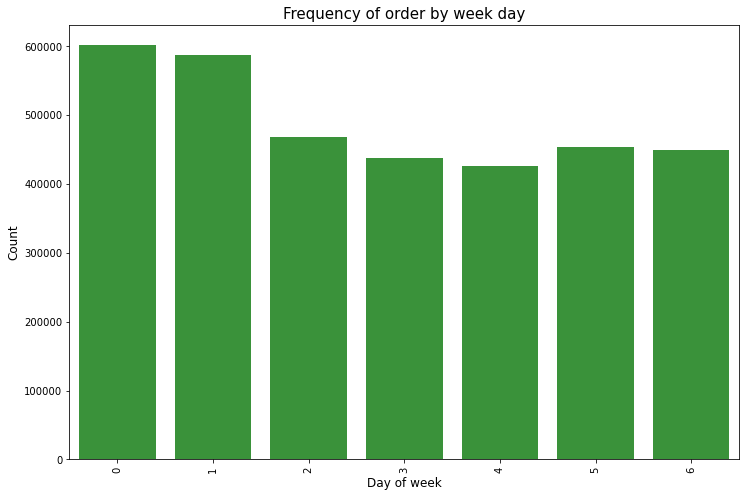

In [75]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[2])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

Seems like 0 and 1 correspond to Saturday and Sunday, as it makes sense that they order more then. Wednesday (4) seems to be when it tapers down.m

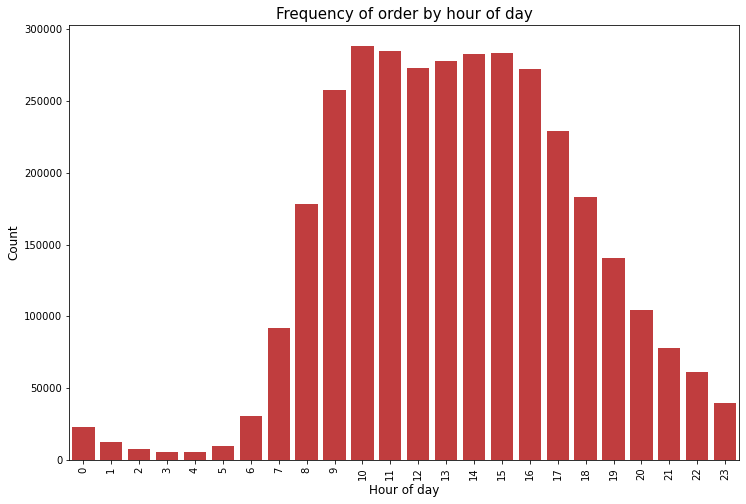

In [76]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Most of the orders are done during day time, between 9am and 5pm.

### Time between orders 

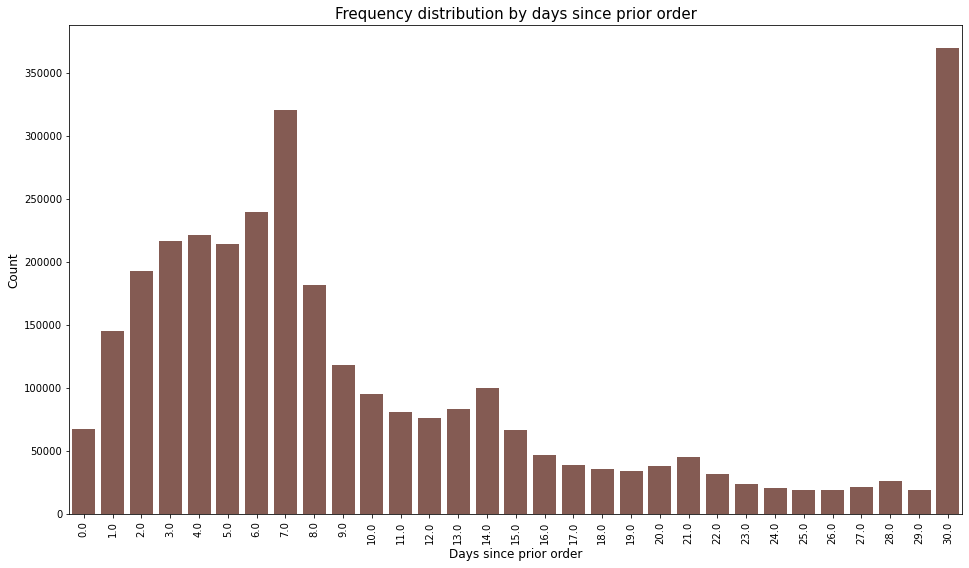

In [77]:
plt.figure(figsize=(16,9))
sns.countplot(x="days_since_prior_order", data=orders, color=color[5])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

There seems to be a trend where customers order on the 7th day, possibly a weekly habit. There are also peaks at 14 and 21 days too - customers who bought on weekends might only do so then, and increase the chances of it being in multiples of 7. There is a huge peak for 30 days- could be monthly grocery shopping.

### Re-ordering

In [213]:
# percentage of re-orders in prior set 
prior.reordered.sum() / prior.shape[0]

0.5896974667922161

In [214]:
# percentage of re-orders in train set 
train.reordered.sum() / train.shape[0]

0.5985944127509629

On average, more than half the items or about 59% of them are re-ordered items

### Highest purchased items

In [242]:
frequent_purchases = prior_new['product_name'].value_counts().reset_index().head(20)
frequent_purchases.columns = ['product_name', 'frequency_count']
frequent_purchases

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


The most commonly bought item was bananas!
There also seems to be a lot of organic products that were bought.

### Most important aisles

C:\Users\Asus\anaconda3\envs\dsi\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


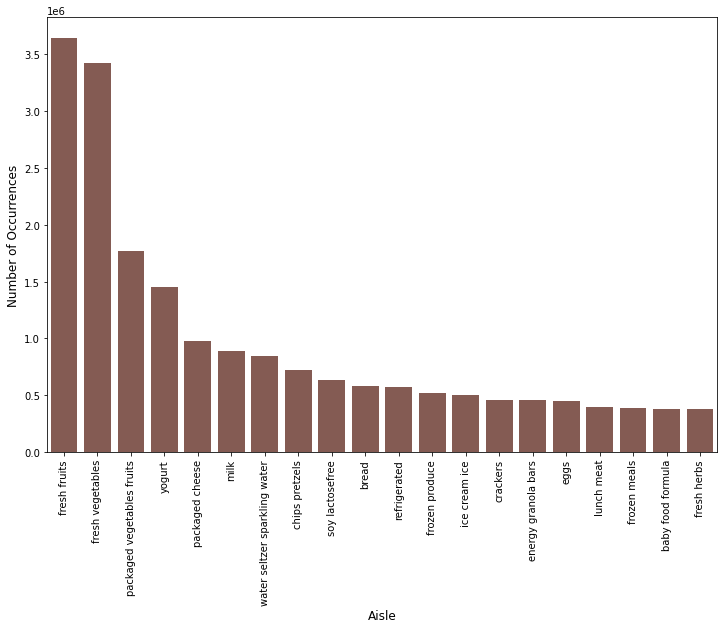

In [79]:
counts = prior_new['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(counts.index, counts.values, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Fruits and vegetables seem to be the highest bought items.

# 1. Baseline model- Recommend all previously bought items 

### Stacking Prior and Train tables

In [33]:
order_products = pd.concat([prior, train], axis=0)
del train, prior

### Concat products function 

In [31]:
def products_concat(vet):
    out = ''
    
    #vet is a pd.Series
    for prod in vet:
        if prod > 0:
            out += str(int(prod)) + ' '
    
    if out != '':
        return out.rstrip()
    else:
        return 'None'

### Combining all data

Combine Orders with our Order_products table, and merge this by user_id using the concat function that was written.

In [34]:
all_data = order_products.merge(orders, on='order_id', how='outer')
del order_products

user_products = all_data.groupby('user_id').product_id.apply(products_concat)

In [91]:
all_data

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120.0,1.0,1.0,202279,prior,3,5,9,8.0
1,2,28985.0,2.0,1.0,202279,prior,3,5,9,8.0
2,2,9327.0,3.0,0.0,202279,prior,3,5,9,8.0
3,2,45918.0,4.0,1.0,202279,prior,3,5,9,8.0
4,2,30035.0,5.0,0.0,202279,prior,3,5,9,8.0
...,...,...,...,...,...,...,...,...,...,...
33894101,2728930,NaN,NaN,NaN,206202,test,23,2,17,6.0
33894102,350108,NaN,NaN,NaN,206204,test,5,4,14,14.0
33894103,1043943,NaN,NaN,NaN,206206,test,68,0,20,0.0
33894104,2821651,NaN,NaN,NaN,206207,test,17,2,13,14.0


Generating test set, which contains the user_id and every product they bought.

In [38]:
test_set = all_data.loc[all_data.eval_set == 'test'][['order_id', 'user_id']]
test_set = test_set.join(user_products, on='user_id')

Setting the columns for submission.

In [85]:
submission = pd.DataFrame({'order_id': test_set.order_id, 'products': test_set.product_id})
submission.head()

,order_id,products
33819106,2774568,38596 21903 248 40604 8021 17668 21137 23650 3...
33819107,329954,22199 25146 1200 17769 43704 37646 11865 35469...
33819108,1528013,38293 20323 40992 21903 45007 11068 10644 4940...
33819109,1376945,8230 30480 22950 34551 44632 15261 33037 20383...
33819110,1356845,13176 14992 44422 11520 31506 22959 7120 37687...


In [89]:
submission = submission.reset_index(drop=True)

Created an appropriate submission format.

In [90]:
submission.head()

,order_id,products
0,2774568,38596 21903 248 40604 8021 17668 21137 23650 3...
1,329954,22199 25146 1200 17769 43704 37646 11865 35469...
2,1528013,38293 20323 40992 21903 45007 11068 10644 4940...
3,1376945,8230 30480 22950 34551 44632 15261 33037 20383...
4,1356845,13176 14992 44422 11520 31506 22959 7120 37687...


In [138]:
submission.to_csv('./data/submission_1.csv')

This churned out a kaggle score of 0.12631.

# 2. Improvement to the Baseline: 
### Using only top 50% of frequency for items bought for evaluation

In [39]:
test_set["user_id"].value_counts()

3         1
137121    1
137174    1
137168    1
137162    1
         ..
68598     1
68597     1
68596     1
68595     1
206208    1
Name: user_id, Length: 75000, dtype: int64

In [40]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 33819106 to 33894105
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   order_id    75000 non-null  int64 
 1   user_id     75000 non-null  int64 
 2   product_id  75000 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


Setting an index to the test set so that we can reference it later

In [41]:
test_set["index"] = range(1,len(test_set)+1)

In [42]:
test_set

,order_id,user_id,product_id,index
33819106,2774568,3,38596 21903 248 40604 8021 17668 21137 23650 3...,1
33819107,329954,4,22199 25146 1200 17769 43704 37646 11865 35469...,2
33819108,1528013,6,38293 20323 40992 21903 45007 11068 10644 4940...,3
33819109,1376945,11,8230 30480 22950 34551 44632 15261 33037 20383...,4
33819110,1356845,12,13176 14992 44422 11520 31506 22959 7120 37687...,5
...,...,...,...,...
33894101,2728930,206202,432 2693 49683 432 26620 2693 39279 24852 4249...,74996
33894102,350108,206204,30561 48287 2164 9339 41665 19508 15649 2825 3...,74997
33894103,1043943,206206,11520 20943 13045 35140 28309 38530 27522 1152...,74998
33894104,2821651,206207,39180 36011 45007 44632 19057 30233 27966 2089...,74999


In [170]:
data_test_set = all_data[all_data["eval_set"]== 'test']

In [171]:
data_test_set

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index
33819106,2774568,NaN,NaN,NaN,3,test,13,5,15,11.0,33819107
33819107,329954,NaN,NaN,NaN,4,test,6,3,12,30.0,33819108
33819108,1528013,NaN,NaN,NaN,6,test,4,3,16,22.0,33819109
33819109,1376945,NaN,NaN,NaN,11,test,8,6,11,8.0,33819110
33819110,1356845,NaN,NaN,NaN,12,test,6,1,20,30.0,33819111
...,...,...,...,...,...,...,...,...,...,...,...
33894101,2728930,NaN,NaN,NaN,206202,test,23,2,17,6.0,33894102
33894102,350108,NaN,NaN,NaN,206204,test,5,4,14,14.0,33894103
33894103,1043943,NaN,NaN,NaN,206206,test,68,0,20,0.0,33894104
33894104,2821651,NaN,NaN,NaN,206207,test,17,2,13,14.0,33894105


Finding the top 50% of value-counts for the items. 

In [156]:
list = []
for i in data_test_set["user_id"].unique():     #these are only for the user_ids within the test set 
    df= all_data[all_data["user_id"]==i]
    lowest = df.sort_values('product_id',ascending=False).head(int(df.shape[0]*.5))
    for i in lowest["index"]:
        list.append(i)

bought_50 = all_data.loc[all_data["index"].isin(list)]  


In [81]:
bought_50 #dataframe containing the top 50% of items bought

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index
0,113,13,27407.0,2.0,0.0,45082,prior,2,6,17,1.0,114
1,114,13,35419.0,3.0,0.0,45082,prior,2,6,17,1.0,115
2,116,13,44635.0,5.0,0.0,45082,prior,2,6,17,1.0,117
3,117,13,26878.0,6.0,0.0,45082,prior,2,6,17,1.0,118
4,118,13,25783.0,7.0,0.0,45082,prior,2,6,17,1.0,119
...,...,...,...,...,...,...,...,...,...,...,...,...
5914983,32434455,3421079,30136.0,1.0,0.0,108687,prior,6,1,13,0.0,32434456
5914984,32434480,3421083,45309.0,2.0,0.0,25247,prior,24,2,6,21.0,32434481
5914985,32434483,3421083,35211.0,5.0,0.0,25247,prior,24,2,6,21.0,32434484
5914986,32434484,3421083,39678.0,6.0,1.0,25247,prior,24,2,6,21.0,32434485


In [158]:
bought_50.to_csv('./data/bought_50.csv')

In [47]:
bought_50["eval_set"].value_counts()

prior    5914988
Name: eval_set, dtype: int64

In [48]:
test_set_50 = bought_50[['order_id', 'user_id']]

In [49]:
test_set_50

,order_id,user_id
0,13,45082
1,13,45082
2,13,45082
3,13,45082
4,13,45082
...,...,...
5914983,3421079,108687
5914984,3421083,25247
5914985,3421083,25247
5914986,3421083,25247


Application of the products_concat to get the products the test set bought

In [50]:
user_products_short = bought_50.groupby('user_id').product_id.apply(products_concat)

In [51]:
user_products_short

user_id
3         38596 40604 23650 32402 39190 47766 43961 4776...
4         25146 43704 37646 35469 42329 26576 25623 3660...
6                 38293 40992 45007 49401 27521 38293 48679
11        30480 34551 44632 33037 35321 40738 41319 2846...
12        44422 31506 22959 37687 39667 28134 30489 4968...
                                ...                        
206202    49683 26620 39279 24852 42495 28468 34969 3728...
206204    30561 48287 41665 30855 46906 43961 33754 4230...
206206    35140 28309 38530 27522 49325 38303 27999 3514...
206207    39180 36011 45007 44632 30233 31893 39040 4423...
206208    34213 43295 39475 27744 31717 43129 45007 4308...
Name: product_id, Length: 75000, dtype: object

In [52]:
test_set_50 = test_set_50.join(user_products_short, on='user_id')

In [53]:
test_set_50

,order_id,user_id,product_id
0,13,45082,27407 35419 44635 26878 25783 41290 33198 2302...
1,13,45082,27407 35419 44635 26878 25783 41290 33198 2302...
2,13,45082,27407 35419 44635 26878 25783 41290 33198 2302...
3,13,45082,27407 35419 44635 26878 25783 41290 33198 2302...
4,13,45082,27407 35419 44635 26878 25783 41290 33198 2302...
...,...,...,...
5914983,3421079,108687,31730 27454 36085 37141 44275 40709 28547 4697...
5914984,3421083,25247,34243 39973 27845 38051 34221 40593 28842 4776...
5914985,3421083,25247,34243 39973 27845 38051 34221 40593 28842 4776...
5914986,3421083,25247,34243 39973 27845 38051 34221 40593 28842 4776...


In [92]:
test_set_50_dropped = test_set_50.drop_duplicates(subset=['user_id'])

In [95]:
test_50_sorted = test_set_50_dropped.sort_values("user_id")
test_50_sorted

,order_id,user_id,product_id
767643,444309,3,38596 40604 23650 32402 39190 47766 43961 4776...
163641,94891,4,25146 43704 37646 35469 42329 26576 25623 3660...
516843,298250,6,38293 40992 45007 49401 27521 38293 48679
1368580,790927,11,30480 34551 44632 33037 35321 40738 41319 2846...
385058,221248,12,44422 31506 22959 37687 39667 28134 30489 4968...
...,...,...,...
63303,36819,206202,49683 26620 39279 24852 42495 28468 34969 3728...
136296,79277,206204,30561 48287 41665 30855 46906 43961 33754 4230...
7558,4277,206206,35140 28309 38530 27522 49325 38303 27999 3514...
16635,9620,206207,39180 36011 45007 44632 30233 31893 39040 4423...


In [96]:
test_50_sorted = test_50_sorted.drop("order_id", axis = 1)

In [285]:
submission_2 = pd.DataFrame({'order_id': test_50_sorted.order_id, 'products': test_50_sorted.product_id})
submission_2.head()

,order_id,products
4210776,2774568,38596 40604 23650 32402 39190 47766 43961 4776...
897543,329954,25146 43704 37646 35469 42329 26576 25623 3660...
2825846,1528013,38293 40992 45007 49401 27521 38293 48679
7492734,1376945,30480 34551 44632 33037 35321 40738 41319 2846...
2098029,1356845,44422 31506 22959 37687 39667 28134 30489 4968...


In [286]:
submission_2.to_csv('./data/submission_2.csv', index=False)

This churned out a Kaggle score of 0.11949.

# Collaborative filtering- user-based. 

### Merging the basket for  50% frequency between closest match and target to improve score.

In [108]:
df3 = pd.read_csv("./data/df3.csv")

### Drop rows from dataset

Our dataset is quite huge, and building a recommendation system using the entire dataset might be too intense of a computation job. We will be removing certain parts of the dataset to acheive a more manageable dataset, and build a recommender based on that.

Pre-processing: Only work with users that are NOT in the test set

1) Drop products that were ordered less than 200 times out of a total of more than 300 million orders.

2) Keep users that have made at least 20 orders.

3) Evaluate the dataset to see if feasible- will cut down to acheive a manageable size.

###### Add in the test set 

Note that the each user's final order either contributes as a train set, or a test set.

For non-test users, we will want to keep a third of them to do collaborative filtering.

We would like to keep ALL the test sets.

In [109]:
df3["eval_set"].value_counts()

prior    32434489
Name: eval_set, dtype: int64

In [139]:
train = orders[orders['eval_set']=='train']
user_ids = train['user_id'].values
orders_train = orders[orders['user_id'].isin(user_ids)]
orders_train.shape

(2178586, 7)

In [ ]:
orders_train_new = orders_train.merge(prior_new,how='left', left_on='order_id', right_on='order_id')

In [ ]:
df_reduced = orders_train_new.groupby('product_id').filter(lambda x: len(x)>200)

###### Keep users that have made at least 20 orders

In [ ]:
user_order_nums = df_reduced.groupby('user_id')['order_number'].agg(['unique'])

In [ ]:
user_order_nums.head()

In [ ]:
user_order_nums = user_order_nums[user_order_nums['unique'].apply(lambda x: len(x) >= 20)]

##### Keep only those 20 orders

In [ ]:
# sort the order numbers in the list
user_order_nums['unique'] = user_order_nums['unique'].apply(sorted)

In [ ]:
# get the last 20 values in the list
user_order_nums['unique'] = user_order_nums['unique'].apply(lambda x: x[-20:])

In [ ]:
user_order_nums.rename(columns={'unique': 'last_20_order_nums'}, inplace=True)

In [ ]:
# drop all orders except the last 20 orders of the selected users 
# create a list of tuples for each (user_id, order_number) combination
user_list = []
order_num_list = []

for i, user in enumerate(user_order_nums.index):
    for order_num in user_order_nums['last_20_order_nums'].iloc[i]:
        user_list.append(user)
        order_num_list.append(order_num)

In [ ]:
# list of tuples (user_id, order_number)
tuple_filt_list = list(zip(user_list, order_num_list))

In [415]:
# keep only orders in the list of tuples
df_reduced = df_reduced[df_reduced[['user_id', 'order_number']].apply(tuple, axis=1).isin(tuple_filt_list)]

In [416]:
# sort df so that the orders and products in each order are in sequence
df_reduced.sort_values(['user_id', 'order_number', 'add_to_cart_order'], inplace=True)

In [417]:
df_reduced

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,aisle,product_id,product_name,department_id,department,add_to_cart_order,reordered
301,2565571,7,prior,1,3,9,NaN,123.0,packaged vegetables fruits,39275.0,Organic Blueberries,4.0,produce,2.0,0.0
299,2565571,7,prior,1,3,9,NaN,112.0,bread,6361.0,Soft Potato Bread,3.0,bakery,3.0,0.0
300,2565571,7,prior,1,3,9,NaN,24.0,fresh fruits,45066.0,Honeycrisp Apple,4.0,produce,4.0,0.0
296,2565571,7,prior,1,3,9,NaN,84.0,milk,13249.0,Skim Milk,16.0,dairy eggs,5.0,0.0
303,2565571,7,prior,1,3,9,NaN,31.0,refrigerated,31683.0,Original No Pulp 100% Florida Orange Juice,7.0,beverages,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20772893,1909878,206200,prior,23,0,19,1.0,19.0,oils vinegars,49585.0,Organic Refined Coconut Oil,13.0,pantry,26.0,1.0
20772892,1909878,206200,prior,23,0,19,1.0,17.0,baking ingredients,44912.0,Baking Powder,13.0,pantry,27.0,0.0
20772913,1909878,206200,prior,23,0,19,1.0,77.0,soft drinks,18418.0,Ginger Ale Soda,7.0,beverages,28.0,0.0
20772894,1909878,206200,prior,23,0,19,1.0,104.0,spices seasonings,46359.0,Organic Ground Ginger,13.0,pantry,29.0,0.0


We are only keeping the top 2_000_000 of the data as there might be memory issues later on.

In [451]:
df_reduced = df_reduced.copy().head(2_000_000)

### We cannot shave the test set to only those that have 20 orders and more as not al of them have 20 orders.

###### We will use them in its entirety so that we do not lose any test datapoints.
###### However, shaving off products that were not commonly bought is still a possibillity - the entire user will not disappear as it is likely that he/she will not only buy those obsure items.

In [444]:
test = orders[orders['eval_set']=='test']
user_ids = test['user_id'].values
orders_test_2 = orders[orders['user_id'].isin(user_ids)]

In [447]:
orders_test_new_1 = orders_test_2.merge(prior_new,how='left', left_on='order_id', right_on='order_id')

In [448]:
orders_test_new = orders_test_new_1.groupby('product_id').filter(lambda x: len(x)>200)

In [449]:
orders_test_new

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,aisle,product_id,product_name,department_id,department,add_to_cart_order,reordered
0,1374495,3,prior,1,1,14,NaN,91.0,soy lactosefree,17668.0,Unsweetened Chocolate Almond Breeze Almond Milk,16.0,dairy eggs,2.0,0.0
1,1374495,3,prior,1,1,14,NaN,91.0,soy lactosefree,39190.0,Vanilla Unsweetened Almond Milk,16.0,dairy eggs,5.0,0.0
2,1374495,3,prior,1,1,14,NaN,78.0,crackers,24810.0,Organic Lightly Salted Brown Rice Cakes,19.0,snacks,9.0,0.0
3,1374495,3,prior,1,1,14,NaN,78.0,crackers,32402.0,"Crackers, Crispy, Cheddar",19.0,snacks,10.0,0.0
4,1374495,3,prior,1,1,14,NaN,24.0,fresh fruits,9387.0,Granny Smith Apples,4.0,produce,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11867492,1882108,206208,prior,49,1,22,7.0,83.0,fresh vegetables,45007.0,Organic Zucchini,4.0,produce,9.0,1.0
11867493,1882108,206208,prior,49,1,22,7.0,123.0,packaged vegetables fruits,2643.0,Organic Bagged Kale Salad Mix,4.0,produce,13.0,1.0
11867494,1882108,206208,prior,49,1,22,7.0,123.0,packaged vegetables fruits,43961.0,Organic Peeled Whole Baby Carrots,4.0,produce,8.0,1.0
11867495,1882108,206208,prior,49,1,22,7.0,123.0,packaged vegetables fruits,44910.0,Organic Spring Mix Salad,4.0,produce,11.0,1.0


Merging the test data with the previous df_reduced, which is the train data (but only 2_000_000 rows).

In [ ]:
df_reduced = df_reduced.copy().append(orders_test_new)

### Creating a Matrix

In [480]:
df_reduced_svd = df_reduced.copy()

In [481]:
df_reduced_svd["value"] = 1

In [482]:
df_new= df_reduced_svd.filter(['user_id', 'product_id','value'])

In [483]:
downcasting(df_new)

In [485]:
df_matrix = df_new.groupby(['user_id', 'product_id']).agg('size').unstack()

# Recommender System - Cosine Similarity

In [4]:
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [ ]:
df_matrix.to_csv('./data/df_matrix_2.csv')

In [493]:
df_matrix.shape

(85280, 11091)

In [508]:
def split_dataframe(df, chunk_size = 21320): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [509]:
split = split_dataframe(df_matrix)

We need to split the data due to computational issues. 
This will reduce our cosine similarity - each point cannot compare to 80,000 other users, but 20,000 would suffice for now. 

In [510]:
df_matrix_1 = split[0]

In [511]:
df_matrix_2 = split[1]

In [512]:
df_matrix_3 = split[2]

In [513]:
df_matrix_4 = split[3]

In [515]:
df_matrix_1.to_csv('./data/df_matrix_1.csv')

In [516]:
df_matrix_2.to_csv('./data/df_matrix_2.csv')

In [517]:
df_matrix_3.to_csv('./data/df_matrix_3.csv')

In [518]:
df_matrix_4.to_csv('./data/df_matrix_4.csv')

In [6]:
df_matrix_1 = pd.read_csv("./data/df_matrix_1.csv")

In [7]:
df_matrix_2 = pd.read_csv("./data/df_matrix_2.csv")

In [8]:
df_matrix_3 = pd.read_csv("./data/df_matrix_3.csv")

In [9]:
df_matrix_4 = pd.read_csv("./data/df_matrix_4.csv")

In [47]:
df_matrix_1 = df_matrix_1.set_index("user_id")

In [48]:
df_matrix_2 = df_matrix_2.set_index("user_id")

In [49]:
df_matrix_3 = df_matrix_3.set_index("user_id")

In [50]:
df_matrix_4 = df_matrix_4.set_index("user_id")

# For Matrix 1

In [51]:
sparse_pivot = sparse.csr_matrix(df_matrix_1.fillna(0))
print(sparse_pivot)

  (0, 54)	1.0
  (0, 393)	3.0
  (0, 1657)	1.0
  (0, 1776)	1.0
  (0, 2076)	5.0
  (0, 2867)	1.0
  (0, 3361)	2.0
  (0, 3392)	1.0
  (0, 3739)	3.0
  (0, 3780)	2.0
  (0, 3936)	5.0
  (0, 4102)	1.0
  (0, 4158)	4.0
  (0, 4708)	1.0
  (0, 4874)	8.0
  (0, 4908)	3.0
  (0, 5279)	2.0
  (0, 5360)	2.0
  (0, 5516)	3.0
  (0, 6300)	2.0
  (0, 7200)	3.0
  (0, 8656)	1.0
  (0, 8796)	10.0
  (0, 8962)	1.0
  (0, 9112)	1.0
  :	:
  (21319, 1320)	1.0
  (21319, 1816)	2.0
  (21319, 1866)	6.0
  (21319, 2746)	1.0
  (21319, 3615)	1.0
  (21319, 3764)	1.0
  (21319, 3780)	18.0
  (21319, 3790)	4.0
  (21319, 4397)	2.0
  (21319, 4708)	1.0
  (21319, 4878)	3.0
  (21319, 4994)	1.0
  (21319, 5109)	2.0
  (21319, 5130)	6.0
  (21319, 5239)	1.0
  (21319, 5309)	5.0
  (21319, 5407)	4.0
  (21319, 5578)	1.0
  (21319, 5605)	2.0
  (21319, 5751)	3.0
  (21319, 7595)	3.0
  (21319, 9397)	2.0
  (21319, 9901)	3.0
  (21319, 10413)	1.0
  (21319, 10648)	1.0


In [52]:
# Note that a distance of 1 is a similarity of 0.
dists = pairwise_distances(sparse_pivot, metric='cosine')

dists

array([[0.        , 1.        , 0.8144296 , ..., 0.95945505, 0.91889879,
        0.93063872],
       [1.        , 0.        , 1.        , ..., 0.9515534 , 1.        ,
        0.99076013],
       [0.8144296 , 1.        , 0.        , ..., 0.97057398, 1.        ,
        1.        ],
       ...,
       [0.95945505, 0.9515534 , 0.97057398, ..., 0.        , 0.96296241,
        0.99429258],
       [0.91889879, 1.        , 1.        , ..., 0.96296241, 0.        ,
        1.        ],
       [0.93063872, 0.99076013, 1.        , ..., 0.99429258, 1.        ,
        0.        ]])

In [53]:
similarities = cosine_similarity(sparse_pivot)

In [54]:
recommender_df = pd.DataFrame(dists, 
                              columns=df_matrix_1.index, 
                              index=df_matrix_1.index)
recommender_df.head()

user_id,3,4,6,7,11,12,15,16,17,19,...,40994,40997,40998,40999,41000,41002,41004,41005,41008,41010
user_id,,,,,,,,,,,,,,,,,,,,,
3,0.000000,1.0,0.81443,0.983898,1.000000,0.949515,1.0,0.828379,0.943500,0.984345,...,1.0,0.987977,1.000000,0.989283,0.975402,0.997263,0.987345,0.959455,0.918899,0.930639
4,1.000000,0.0,1.00000,1.000000,1.000000,0.975116,1.0,1.000000,0.876229,1.000000,...,1.0,1.000000,1.000000,1.000000,0.947287,0.993255,0.987525,0.951553,1.000000,0.990760
6,0.814430,1.0,0.00000,1.000000,0.965890,1.000000,1.0,0.808820,1.000000,1.000000,...,1.0,1.000000,1.000000,0.969198,1.000000,0.967226,0.975754,0.970574,1.000000,1.000000
7,0.983898,1.0,1.00000,0.000000,0.993542,0.984739,1.0,0.910723,1.000000,0.996214,...,1.0,0.998183,0.966148,0.952053,0.901078,0.999173,0.954098,0.924237,0.963227,0.984134
11,1.000000,1.0,0.96589,0.993542,0.000000,0.962881,1.0,0.988262,1.000000,0.990792,...,1.0,0.986740,0.956085,0.968481,0.965402,0.991951,0.988835,0.980127,0.955278,1.000000


In [55]:
recommender_df.tail()

user_id,3,4,6,7,11,12,15,16,17,19,...,40994,40997,40998,40999,41000,41002,41004,41005,41008,41010
user_id,,,,,,,,,,,,,,,,,,,,,
41002,0.997263,0.993255,0.967226,0.999173,0.991951,0.982881,1.000000,0.979699,1.000000,1.000000,...,1.000000,0.967723,1.000000,0.983040,0.974614,0.000000,0.998570,0.953476,0.980520,1.000000
41004,0.987345,0.987525,0.975754,0.954098,0.988835,0.936675,1.000000,0.983312,1.000000,1.000000,...,1.000000,0.996858,0.988294,1.000000,0.986585,0.998570,0.000000,0.988442,0.983045,1.000000
41005,0.959455,0.951553,0.970574,0.924237,0.980127,0.884721,1.000000,0.918990,0.994425,1.000000,...,1.000000,0.992374,0.857932,0.870569,0.863247,0.953476,0.988442,0.000000,0.962962,0.994293
41008,0.918899,1.000000,1.000000,0.963227,0.955278,0.949270,1.000000,0.943184,0.992115,0.997378,...,1.000000,0.982381,0.910911,0.894102,0.947164,0.980520,0.983045,0.962962,0.000000,1.000000
41010,0.930639,0.990760,1.000000,0.984134,1.000000,0.992183,0.921041,0.990730,1.000000,0.849709,...,0.730614,1.000000,0.956647,0.993362,0.991720,1.000000,1.000000,0.994293,1.000000,0.000000


# Iterating through the list for similar users

In [56]:
second_small_list = []
for i in recommender_df.columns:
    item = (recommender_df[i].nsmallest(2).index)[1]
    second_small_list.append(item)

In [57]:
second_small_list

[27868,
 29199,
 6320,
 23642,
 39034,
 16652,
 35209,
 32592,
 22899,
 15275,
 20303,
 8182,
 6884,
 18919,
 20623,
 29659,
 14597,
 30645,
 34850,
 4353,
 24657,
 11065,
 10365,
 6672,
 30721,
 32018,
 14931,
 4621,
 38361,
 17082,
 36162,
 38554,
 10806,
 23432,
 12190,
 17961,
 22450,
 26489,
 11268,
 807,
 1387,
 23153,
 12888,
 35439,
 28241,
 34869,
 14965,
 25797,
 23915,
 25076,
 37481,
 26873,
 26988,
 3182,
 28472,
 31150,
 36340,
 35466,
 32910,
 9729,
 25158,
 20046,
 40497,
 9614,
 22341,
 19880,
 911,
 34016,
 276,
 21341,
 14090,
 11773,
 23180,
 26091,
 834,
 22388,
 40997,
 8900,
 22811,
 6821,
 30558,
 17534,
 12888,
 31359,
 37442,
 4653,
 17297,
 11036,
 19766,
 28292,
 29498,
 6884,
 4435,
 16697,
 13068,
 29067,
 14490,
 39604,
 12150,
 12618,
 21451,
 1387,
 3733,
 28632,
 13812,
 20046,
 2921,
 40627,
 1171,
 8323,
 1531,
 14922,
 37404,
 17997,
 4618,
 16998,
 40193,
 17090,
 1029,
 807,
 32974,
 4310,
 20623,
 34270,
 18521,
 13479,
 35638,
 32863,
 17534,
 1

In [58]:
closest = pd.DataFrame (second_small_list, columns = ['closest'])
print (closest)

       closest
0        27868
1        29199
2         6320
3        23642
4        39034
...        ...
21315     4440
21316    34522
21317    29623
21318     4807
21319    13264

[21320 rows x 1 columns]


In [59]:
list_2 = []
for i in recommender_df.columns:
    list_2.append(i)
    
user_ids = pd.DataFrame (list_2, columns = ['users'])

In [60]:
matched = pd.concat([user_ids, closest], axis=1)
matched

,users,closest
0,3,27868
1,4,29199
2,6,6320
3,7,23642
4,11,39034
...,...,...
21315,41002,4440
21316,41004,34522
21317,41005,29623
21318,41008,4807


# Matrix 2

In [61]:
sparse_pivot2 = sparse.csr_matrix(df_matrix_2.fillna(0))
print(sparse_pivot2)

  (0, 558)	2.0
  (0, 1255)	1.0
  (0, 3374)	1.0
  (0, 4639)	2.0
  (0, 5223)	1.0
  (0, 6214)	1.0
  (0, 7265)	1.0
  (0, 7456)	2.0
  (0, 8854)	1.0
  (0, 10400)	1.0
  (0, 10657)	1.0
  (1, 5)	1.0
  (1, 10)	4.0
  (1, 15)	1.0
  (1, 74)	1.0
  (1, 208)	2.0
  (1, 334)	2.0
  (1, 367)	7.0
  (1, 455)	3.0
  (1, 470)	2.0
  (1, 486)	1.0
  (1, 782)	1.0
  (1, 802)	1.0
  (1, 825)	3.0
  (1, 889)	3.0
  :	:
  (21319, 1235)	1.0
  (21319, 1284)	1.0
  (21319, 1291)	2.0
  (21319, 1872)	2.0
  (21319, 2582)	1.0
  (21319, 2638)	1.0
  (21319, 3420)	1.0
  (21319, 3608)	1.0
  (21319, 4584)	1.0
  (21319, 4884)	2.0
  (21319, 5109)	1.0
  (21319, 5128)	1.0
  (21319, 5206)	1.0
  (21319, 5481)	1.0
  (21319, 5920)	2.0
  (21319, 6029)	1.0
  (21319, 6695)	1.0
  (21319, 7686)	2.0
  (21319, 8064)	2.0
  (21319, 8271)	1.0
  (21319, 8606)	1.0
  (21319, 9104)	1.0
  (21319, 9934)	1.0
  (21319, 10671)	1.0
  (21319, 11090)	1.0


In [62]:
dists2 = pairwise_distances(sparse_pivot2, metric='cosine')

dists2

array([[0.        , 1.        , 1.        , ..., 0.92244333, 1.        ,
        1.        ],
       [1.        , 0.        , 0.89305184, ..., 0.97615365, 1.        ,
        0.96583666],
       [1.        , 0.89305184, 0.        , ..., 1.        , 1.        ,
        0.98343653],
       ...,
       [0.92244333, 0.97615365, 1.        , ..., 0.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        0.89672044],
       [1.        , 0.96583666, 0.98343653, ..., 1.        , 0.89672044,
        0.        ]])

In [63]:
similarities2 = cosine_similarity(sparse_pivot2)

In [64]:
recommender_df2 = pd.DataFrame(dists2, 
                              columns=df_matrix_2.index, 
                              index=df_matrix_2.index)
recommender_df2.head()

user_id,41013,41014,41015,41017,41018,41019,41020,41022,41026,41027,...,88882,88887,88894,88896,88897,88898,88900,88901,88908,88909
user_id,,,,,,,,,,,,,,,,,,,,,
41013,0.000000,1.000000,1.000000,1.00000,0.974518,0.948339,1.000000,1.000000,1.000000,0.902667,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.922443,1.000000,1.000000
41014,1.000000,0.000000,0.893052,0.99683,0.853746,0.933438,0.925344,0.970366,0.960645,0.931279,...,1.0,1.0,0.993242,0.979629,1.000000,1.0,0.981808,0.976154,1.000000,0.965837
41015,1.000000,0.893052,0.000000,1.00000,0.797403,0.904652,0.918872,0.952109,0.960716,0.897896,...,1.0,1.0,1.000000,0.987654,1.000000,1.0,1.000000,1.000000,1.000000,0.983437
41017,1.000000,0.996830,1.000000,0.00000,1.000000,0.995434,0.986402,0.980124,0.926633,0.991636,...,1.0,1.0,0.989801,0.677200,0.995581,1.0,0.967771,1.000000,0.984026,0.989689
41018,0.974518,0.853746,0.797403,1.00000,0.000000,0.887162,0.935993,0.967254,0.959709,0.867719,...,1.0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000


In [65]:
second_small_list2 = []
for i in recommender_df2.columns:
    item = (recommender_df2[i].nsmallest(2).index)[1]
    second_small_list2.append(item)

In [66]:
closest2 = pd.DataFrame (second_small_list2, columns = ['closest2'])
print (closest2)

       closest2
0         88700
1         68720
2         46728
3         41067
4         64768
...         ...
21315     87054
21316     60670
21317     62203
21318     74769
21319     62547

[21320 rows x 1 columns]


In [67]:
list_22 = []
for i in recommender_df2.columns:
    list_22.append(i)
    
user_ids2 = pd.DataFrame (list_22, columns = ['users'])

In [68]:
matched2 = pd.concat([user_ids2, closest2], axis=1)
matched2

,users,closest2
0,41013,88700
1,41014,68720
2,41015,46728
3,41017,41067
4,41018,64768
...,...,...
21315,88898,87054
21316,88900,60670
21317,88901,62203
21318,88908,74769


# Matrix 3

In [69]:
sparse_pivot3 = sparse.csr_matrix(df_matrix_3.fillna(0))
print(sparse_pivot3)

  (0, 96)	1.0
  (0, 180)	5.0
  (0, 207)	2.0
  (0, 317)	2.0
  (0, 423)	1.0
  (0, 433)	3.0
  (0, 487)	2.0
  (0, 503)	1.0
  (0, 516)	1.0
  (0, 546)	2.0
  (0, 870)	1.0
  (0, 892)	1.0
  (0, 1003)	1.0
  (0, 1065)	3.0
  (0, 1098)	1.0
  (0, 1129)	1.0
  (0, 1195)	1.0
  (0, 1280)	2.0
  (0, 1284)	2.0
  (0, 1362)	4.0
  (0, 1498)	5.0
  (0, 1714)	1.0
  (0, 1836)	5.0
  (0, 1881)	17.0
  (0, 1974)	1.0
  :	:
  (21319, 2844)	1.0
  (21319, 2946)	1.0
  (21319, 2957)	3.0
  (21319, 3361)	2.0
  (21319, 3739)	1.0
  (21319, 3996)	3.0
  (21319, 4462)	1.0
  (21319, 4708)	2.0
  (21319, 5009)	3.0
  (21319, 5109)	1.0
  (21319, 5563)	1.0
  (21319, 6255)	1.0
  (21319, 6263)	1.0
  (21319, 6448)	1.0
  (21319, 6482)	1.0
  (21319, 6669)	2.0
  (21319, 6828)	1.0
  (21319, 7679)	1.0
  (21319, 8571)	1.0
  (21319, 8901)	1.0
  (21319, 9086)	1.0
  (21319, 9556)	1.0
  (21319, 10080)	1.0
  (21319, 10246)	1.0
  (21319, 10747)	1.0


In [70]:
dists3 = pairwise_distances(sparse_pivot3, metric='cosine')

dists3

array([[0.        , 0.99857313, 0.99202164, ..., 0.99715764, 1.        ,
        0.95329525],
       [0.99857313, 0.        , 0.99595476, ..., 1.        , 1.        ,
        1.        ],
       [0.99202164, 0.99595476, 0.        , ..., 1.        , 1.        ,
        0.99509592],
       ...,
       [0.99715764, 1.        , 1.        , ..., 0.        , 1.        ,
        0.98340235],
       [1.        , 1.        , 1.        , ..., 1.        , 0.        ,
        1.        ],
       [0.95329525, 1.        , 0.99509592, ..., 0.98340235, 1.        ,
        0.        ]])

In [71]:
similarities3 = cosine_similarity(sparse_pivot3)

In [72]:
recommender_df3 = pd.DataFrame(dists3, 
                              columns=df_matrix_3.index, 
                              index=df_matrix_3.index)
recommender_df3.head()

user_id,88911,88914,88918,88919,88921,88922,88924,88926,88928,88932,...,147278,147282,147283,147284,147288,147291,147296,147297,147298,147304
user_id,,,,,,,,,,,,,,,,,,,,,
88911,0.000000,0.998573,0.992022,0.970065,0.925086,0.891146,1.0,0.909819,0.959687,0.824605,...,0.969217,0.995952,0.945259,1.000000,0.99473,0.919000,1.000000,0.997158,1.0,0.953295
88914,0.998573,0.000000,0.995955,1.000000,0.982991,0.994174,1.0,0.866024,0.966949,0.996155,...,1.000000,1.000000,0.959617,0.982523,1.00000,0.997847,0.995165,1.000000,1.0,1.000000
88918,0.992022,0.995955,0.000000,0.994857,1.000000,0.993142,1.0,0.990181,1.000000,0.986423,...,0.988812,0.994899,0.991611,1.000000,1.00000,0.975921,0.994308,1.000000,1.0,0.995096
88919,0.970065,1.000000,0.994857,0.000000,1.000000,0.933333,1.0,0.968184,1.000000,0.978003,...,0.992749,1.000000,0.972817,1.000000,1.00000,0.952363,1.000000,1.000000,1.0,0.952327
88921,0.925086,0.982991,1.000000,1.000000,0.000000,0.993821,1.0,0.997788,0.959101,1.000000,...,0.995968,1.000000,0.858906,0.962925,1.00000,0.949300,1.000000,1.000000,1.0,1.000000


In [73]:
second_small_list3 = []
for i in recommender_df3.columns:
    item = (recommender_df3[i].nsmallest(2).index)[1]
    second_small_list3.append(item)

In [74]:
closest3 = pd.DataFrame (second_small_list3, columns = ['closest3'])
print (closest3)

       closest3
0        111893
1         91895
2         91536
3        132989
4        129455
...         ...
21315     97434
21316    106909
21317    139142
21318    136818
21319    107306

[21320 rows x 1 columns]


In [75]:
list_3 = []
for i in recommender_df3.columns:
    list_3.append(i)
    
user_ids3 = pd.DataFrame (list_3, columns = ['users'])

In [76]:
matched3 = pd.concat([user_ids3, closest3], axis=1)
matched3

,users,closest3
0,88911,111893
1,88914,91895
2,88918,91536
3,88919,132989
4,88921,129455
...,...,...
21315,147291,97434
21316,147296,106909
21317,147297,139142
21318,147298,136818


# Matrix 4

In [77]:
sparse_pivot4 = sparse.csr_matrix(df_matrix_4.fillna(0))
print(sparse_pivot4)

  (0, 54)	1.0
  (0, 71)	1.0
  (0, 142)	1.0
  (0, 167)	3.0
  (0, 178)	1.0
  (0, 227)	2.0
  (0, 239)	1.0
  (0, 246)	1.0
  (0, 280)	1.0
  (0, 332)	2.0
  (0, 374)	5.0
  (0, 393)	2.0
  (0, 503)	1.0
  (0, 576)	1.0
  (0, 653)	1.0
  (0, 689)	1.0
  (0, 751)	12.0
  (0, 848)	3.0
  (0, 849)	1.0
  (0, 863)	6.0
  (0, 892)	2.0
  (0, 904)	3.0
  (0, 914)	1.0
  (0, 925)	1.0
  (0, 1003)	1.0
  :	:
  (21319, 9815)	7.0
  (21319, 9826)	2.0
  (21319, 9849)	1.0
  (21319, 9911)	3.0
  (21319, 10006)	1.0
  (21319, 10009)	1.0
  (21319, 10041)	7.0
  (21319, 10066)	5.0
  (21319, 10136)	1.0
  (21319, 10207)	1.0
  (21319, 10318)	7.0
  (21319, 10446)	2.0
  (21319, 10456)	1.0
  (21319, 10489)	2.0
  (21319, 10492)	1.0
  (21319, 10521)	1.0
  (21319, 10566)	1.0
  (21319, 10646)	5.0
  (21319, 10667)	1.0
  (21319, 10671)	1.0
  (21319, 10727)	1.0
  (21319, 10817)	1.0
  (21319, 10918)	1.0
  (21319, 10995)	1.0
  (21319, 11076)	1.0


In [78]:
dists4 = pairwise_distances(sparse_pivot4, metric='cosine')

dists4

array([[0.        , 0.95305401, 0.96085642, ..., 0.94356657, 0.9191954 ,
        0.90507359],
       [0.95305401, 0.        , 0.95175117, ..., 0.77929165, 0.93071255,
        0.94811075],
       [0.96085642, 0.95175117, 0.        , ..., 1.        , 0.89167772,
        0.89616337],
       ...,
       [0.94356657, 0.77929165, 1.        , ..., 0.        , 0.98015053,
        0.91562467],
       [0.9191954 , 0.93071255, 0.89167772, ..., 0.98015053, 0.        ,
        0.81401719],
       [0.90507359, 0.94811075, 0.89616337, ..., 0.91562467, 0.81401719,
        0.        ]])

In [79]:
similarities4 = cosine_similarity(sparse_pivot4)

In [80]:
recommender_df4 = pd.DataFrame(dists4, 
                              columns=df_matrix_4.index, 
                              index=df_matrix_4.index)
recommender_df4.head()

user_id,147318,147319,147320,147322,147323,147324,147327,147332,147335,147336,...,206189,206192,206194,206197,206201,206202,206204,206206,206207,206208
user_id,,,,,,,,,,,,,,,,,,,,,
147318,0.000000,0.953054,0.960856,0.807146,0.982614,1.0,0.902837,0.954473,0.968452,0.883005,...,0.974391,0.99732,0.843935,0.789990,0.972998,0.906692,0.948855,0.943567,0.919195,0.905074
147319,0.953054,0.000000,0.951751,0.958658,1.000000,1.0,0.980039,1.000000,0.982248,0.993691,...,1.000000,1.00000,0.984158,1.000000,0.983158,0.994138,0.985290,0.779292,0.930713,0.948111
147320,0.960856,0.951751,0.000000,0.881815,1.000000,1.0,1.000000,1.000000,0.949251,1.000000,...,1.000000,1.00000,0.994339,1.000000,1.000000,1.000000,1.000000,1.000000,0.891678,0.896163
147322,0.807146,0.958658,0.881815,0.000000,1.000000,1.0,0.986554,0.939862,0.956516,0.969091,...,1.000000,1.00000,0.941793,0.935085,0.984530,0.956921,1.000000,1.000000,0.915141,0.908095
147323,0.982614,1.000000,1.000000,1.000000,0.000000,1.0,0.991129,0.963630,1.000000,0.943923,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
second_small_list4 = []
for i in recommender_df4.columns:
    item = (recommender_df4[i].nsmallest(2).index)[1]
    second_small_list4.append(item)

In [82]:
closest4 = pd.DataFrame (second_small_list4, columns = ['closest2'])
print (closest4)

       closest2
0        201303
1        179321
2        151753
3        204194
4        158367
...         ...
21315    166901
21316    170857
21317    194177
21318    186182
21319    189412

[21320 rows x 1 columns]


In [83]:
list_4 = []
for i in recommender_df4.columns:
    list_4.append(i)
    
user_ids4 = pd.DataFrame (list_4, columns = ['users'])

In [84]:
matched4 = pd.concat([user_ids4, closest4], axis=1)
matched4

,users,closest2
0,147318,201303
1,147319,179321
2,147320,151753
3,147322,204194
4,147323,158367
...,...,...
21315,206202,166901
21316,206204,170857
21317,206206,194177
21318,206207,186182


In [92]:
matched2.rename(columns = {'closest2':'closest'},inplace=True)

In [93]:
matched3.rename(columns = {'closest3':'closest'},inplace=True)

In [102]:
matched4.rename(columns = {'closest2':'closest'},inplace=True)

Appending the split dfs together

In [103]:
matched_total = matched.append(matched2)

In [104]:
matched_total = matched_total.copy().append(matched3)

In [105]:
matched_total = matched_total.copy().append(matched4)

In [106]:
matched_total

,users,closest
0,3,27868
1,4,29199
2,6,6320
3,7,23642
4,11,39034
...,...,...
21315,206202,166901
21316,206204,170857
21317,206206,194177
21318,206207,186182


Finding out only those that are in their test. 

In [185]:
matched_list = matched_total.users.isin(test_list)

In [187]:
matched_df = matched_total[matched_list]

In [188]:
matched_df

,users,closest
0,3,27868
1,4,29199
2,6,6320
4,11,39034
5,12,16652
...,...,...
21315,206202,166901
21316,206204,170857
21317,206206,194177
21318,206207,186182


In [194]:
match_list = []
for i in matched_df["users"]:
    match_list.append(i)

In [195]:
test_list = []
for i in test["user_id"]:
    test_list.append(i)

In [196]:
difference_1 = set(match_list).difference(set(test_list))
difference_2 = set(test_list).difference(set(match_list))

In [197]:
list_difference = list(difference_1.union(difference_2))
print(list_difference)

[167553, 105857, 168963, 147588, 16522, 183315, 142997, 37912, 173085, 106143, 52003, 66343, 81326, 181814, 139324, 142012, 61249, 178626, 38979, 56006, 111303, 128454, 158417, 114897, 202836, 79830, 83034, 84062, 190047, 157152, 50020, 96613, 198641, 32501]


For these missing values, we input the closest pair as their own basket.

In [198]:
matched_df

,users,closest
0,3,27868
1,4,29199
2,6,6320
4,11,39034
5,12,16652
...,...,...
21315,206202,166901
21316,206204,170857
21317,206206,194177
21318,206207,186182


In [ ]:
user_order_nums = df_reduced.groupby('user_id')['order_number'].agg(['unique'])

Finding from reduced dataset of top 50% bought products

In [1]:
# matched_df = pd.read_csv("./data/matched_df.csv")
#saving

In [58]:
matched_df

,users,closest
0,3,27868
1,4,29199
2,6,6320
3,11,39034
4,12,16652
...,...,...
74995,157152,157152
74996,50020,50020
74997,96613,96613
74998,198641,198641


In [59]:
matched_df = matched_df.copy().sort_values(by=["users"])

In [60]:
matched_df

,users,closest
0,3,27868
1,4,29199
2,6,6320
3,11,39034
4,12,16652
...,...,...
74961,206202,166901
74962,206204,170857
74963,206206,194177
74964,206207,186182


In [ ]:
user_products_short = bought_50.groupby('user_id').product_id.apply(products_concat)

In [62]:
bought_50

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index
0,13,27407.0,2.0,0.0,45082,prior,2,6,17,1.0,114
1,13,35419.0,3.0,0.0,45082,prior,2,6,17,1.0,115
2,13,44635.0,5.0,0.0,45082,prior,2,6,17,1.0,117
3,13,26878.0,6.0,0.0,45082,prior,2,6,17,1.0,118
4,13,25783.0,7.0,0.0,45082,prior,2,6,17,1.0,119
...,...,...,...,...,...,...,...,...,...,...,...
5914983,3421079,30136.0,1.0,0.0,108687,prior,6,1,13,0.0,32434456
5914984,3421083,45309.0,2.0,0.0,25247,prior,24,2,6,21.0,32434481
5914985,3421083,35211.0,5.0,0.0,25247,prior,24,2,6,21.0,32434484
5914986,3421083,39678.0,6.0,1.0,25247,prior,24,2,6,21.0,32434485


In [72]:
closest = []
for i in matched_df["closest"]:
    closest.append(i)

In [69]:
all_data["index"] = range(1,len(all_data)+1)

In [70]:
list_matched = []
for i in matched_df["closest"].unique():    
    df= all_data[all_data["user_id"]==i]
    lowest = df.sort_values('product_id',ascending=False).head(int(df.shape[0]*.5))
    for i in lowest["index"]:
        list_matched.append(i)

matchy = all_data.loc[all_data["index"].isin(list_matched)]

In [71]:
matchy

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index
61,8,23423.0,1.0,1.0,3107,prior,5,4,6,17.0,62
140,15,32463.0,5.0,1.0,54901,prior,51,3,11,2.0,141
216,24,40078.0,1.0,0.0,193635,prior,19,0,14,0.0,217
218,24,46175.0,3.0,0.0,193635,prior,19,0,14,0.0,219
325,37,35561.0,1.0,0.0,52564,prior,1,4,17,NaN,326
...,...,...,...,...,...,...,...,...,...,...,...
33818073,3419083,49131.0,10.0,1.0,13944,train,23,3,21,5.0,33818074
33818340,3419435,44422.0,2.0,1.0,38708,train,26,2,9,22.0,33818341
33818341,3419435,27845.0,3.0,1.0,38708,train,26,2,9,22.0,33818342
33818342,3419435,24852.0,4.0,1.0,38708,train,26,2,9,22.0,33818343


In [81]:
len(closest)

75000

In [82]:
matchy_short = matchy.groupby('user_id').product_id.apply(products_concat)

In [83]:
matchy_short

user_id
3         38596 40604 23650 32402 39190 47766 43961 4776...
15        37710 27839 12427 14715 37710 37059 14715 1471...
17        18534 48544 36463 19766 29589 25307 21187 4714...
20        22362 13914 46061 41400 46061 22362 13914 2236...
22        27845 24964 22963 36724 24964 32096 22935 2717...
                                ...                        
206152    30233 34243 34243 34969 39408 34993 35951 3023...
206180    45066 35734 25659 42697 34584 47626 40516 4506...
206183    37687 43122 39408 35140 36082 27966 42265 3554...
206192    46699 39719 24852 42943 28609 31865 43409 4294...
206202    49683 26620 39279 24852 42495 28468 34969 3728...
Name: product_id, Length: 26789, dtype: object

In [84]:
matchy_50 = matchy[['order_id', 'user_id']]

In [85]:
matchy_50 = matchy_50.join(matchy_short, on='user_id')

In [86]:
matchy_50

,order_id,user_id,product_id
61,8,3107,23423 23423 40199 48142 23423 49463 45260 4019...
140,15,54901,32463 36675 34262 44359 31717 49175 49175 4948...
216,24,193635,40078 46175 35221 49111 43154 27966 48642 2734...
218,24,193635,40078 46175 35221 49111 43154 27966 48642 2734...
325,37,52564,35561 33059 43721 40199 35561 40199 35561 4019...
...,...,...,...
33818073,3419083,13944,41540 48415 28204 35992 46069 30169 35948 2620...
33818340,3419435,38708,42944 38689 29397 44422 32192 31292 44479 2258...
33818341,3419435,38708,42944 38689 29397 44422 32192 31292 44479 2258...
33818342,3419435,38708,42944 38689 29397 44422 32192 31292 44479 2258...


In [87]:
matchy_50_dropped = matchy_50.drop_duplicates(subset=['user_id'])

In [102]:
matched_df.rename(columns = {'users':'user_id'}, inplace = True)

This shows those not in the test set that can use matched to our collaborative filtering set

In [103]:
matchy_50_dropped

,order_id,user_id,product_id
61,8,3107,23423 23423 40199 48142 23423 49463 45260 4019...
140,15,54901,32463 36675 34262 44359 31717 49175 49175 4948...
216,24,193635,40078 46175 35221 49111 43154 27966 48642 2734...
325,37,52564,35561 33059 43721 40199 35561 40199 35561 4019...
328,39,184886,48679 28204 49191 31964 28465 44781 28465 2741...
...,...,...,...
29628436,3124805,78336,24619 26889 23734
29709502,3133385,55001,19660 23915 30720
29716541,3134138,82688,29820 47766 43789 35065 33669 31766 46979 2796...
30311318,3197375,160842,32689 44987 32538


In [109]:
matchy_50_dropped.rename(columns = {'product_id':'product_id_matched'}, inplace = True)

C:\Users\Asus\anaconda3\envs\dsi\envs\dsi27tf\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [104]:
test_50_sorted

,user_id,product_id,order_id
767643,3,38596 40604 23650 32402 39190 47766 43961 4776...,2774568
163641,4,25146 43704 37646 35469 42329 26576 25623 3660...,329954
516843,6,38293 40992 45007 49401 27521 38293 48679,1528013
1368580,11,30480 34551 44632 33037 35321 40738 41319 2846...,1376945
385058,12,44422 31506 22959 37687 39667 28134 30489 4968...,1356845
...,...,...,...
63303,206202,49683 26620 39279 24852 42495 28468 34969 3728...,2728930
136296,206204,30561 48287 41665 30855 46906 43961 33754 4230...,350108
7558,206206,35140 28309 38530 27522 49325 38303 27999 3514...,1043943
16635,206207,39180 36011 45007 44632 30233 31893 39040 4423...,2821651


In [130]:
matchy_50_dropped

,order_id,user_id,product_id_matched
61,8,3107,23423 23423 40199 48142 23423 49463 45260 4019...
140,15,54901,32463 36675 34262 44359 31717 49175 49175 4948...
216,24,193635,40078 46175 35221 49111 43154 27966 48642 2734...
325,37,52564,35561 33059 43721 40199 35561 40199 35561 4019...
328,39,184886,48679 28204 49191 31964 28465 44781 28465 2741...
...,...,...,...
29628436,3124805,78336,24619 26889 23734
29709502,3133385,55001,19660 23915 30720
29716541,3134138,82688,29820 47766 43789 35065 33669 31766 46979 2796...
30311318,3197375,160842,32689 44987 32538


In [131]:
#important to match the non-test set to the test set (i.e. still retain 75_000 rows)
matched_total = matched_df.merge(matchy_50_dropped, left_on ="closest", right_on = "user_id", how = "inner")

In [132]:
matched_total

,user_id_x,closest,order_id,user_id_y,product_id_matched
0,3,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...
1,28054,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...
2,30218,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...
3,32949,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...
4,4,29199,321304,29199,26576 30752 26576 27356 30752 47141 29529 3075...
...,...,...,...,...,...
74995,206122,175161,784110,175161,39121 37067 46720 45013 42719 27344 41694 3329...
74996,206131,183313,303796,183313,46522 28083 34320 42677 45622 47865 34449 4386...
74997,206147,184769,14541,184769,41787 30305 47209 31717 49383 42445 29447 4276...
74998,206197,164092,950190,164092,30450 33120 39534 30450 39275 39534 33120


In [136]:
matched_total = matched_total.copy().merge(test_50_sorted, left_on='user_id_x', right_on="user_id")

In [137]:
matched_total

,user_id_x,closest,order_id_x,user_id_y,product_id_matched,user_id,product_id,order_id_y
0,3,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,3,38596 40604 23650 32402 39190 47766 43961 4776...,2774568
1,28054,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,28054,27730 32831 27086 32433 27344 45007 44514 4913...,760239
2,30218,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,30218,47766 28934 47144 41637 47626 45007 41259 4793...,943671
3,32949,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,32949,30290 47766 27521 46990 35163 29307 44359 2966...,2630372
4,4,29199,321304,29199,26576 30752 26576 27356 30752 47141 29529 3075...,4,25146 43704 37646 35469 42329 26576 25623 3660...,329954
...,...,...,...,...,...,...,...,...
74995,206122,175161,784110,175161,39121 37067 46720 45013 42719 27344 41694 3329...,206122,33731 49683 28199 40604 19478 32981 39469 3855...,1968103
74996,206131,183313,303796,183313,46522 28083 34320 42677 45622 47865 34449 4386...,206131,20738 45064 30511 42450 45353 38580 23753 3576...,2964171
74997,206147,184769,14541,184769,41787 30305 47209 31717 49383 42445 29447 4276...,206147,31282 35004 39275 45066 31282 42445 35535 4226...,1772796
74998,206197,164092,950190,164092,30450 33120 39534 30450 39275 39534 33120,206197,30450 35951 29195 48023 30450 42719 30450 3065...,1564541


In [138]:
matched_total.to_csv('./data/matched_total.csv', index=False)

In [139]:
matched_total_new = matched_total.drop(['user_id_y', 'user_id', 'order_id_x', 'order_id_y'], axis=1)

In [142]:
matched_total_new = matched_total_new.copy().sort_values(by=['user_id_x'])

In [143]:
matched_total_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 0 to 55721
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id_x           75000 non-null  int64 
 1   closest             75000 non-null  int64 
 2   product_id_matched  75000 non-null  object
 3   product_id          75000 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [144]:
matched_total.head()

,user_id_x,closest,order_id_x,user_id_y,product_id_matched,user_id,product_id,order_id_y
0,3,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,3,38596 40604 23650 32402 39190 47766 43961 4776...,2774568
1,28054,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,28054,27730 32831 27086 32433 27344 45007 44514 4913...,760239
2,30218,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,30218,47766 28934 47144 41637 47626 45007 41259 4793...,943671
3,32949,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,32949,30290 47766 27521 46990 35163 29307 44359 2966...,2630372
4,4,29199,321304,29199,26576 30752 26576 27356 30752 47141 29529 3075...,4,25146 43704 37646 35469 42329 26576 25623 3660...,329954


In [186]:
matched_total["together2"] =matched_total['product_id_matched'] + matched_total["product_id"]

In [187]:
matched_total

,user_id_x,closest,order_id_x,user_id_y,product_id_matched,user_id,product_id,order_id_y,diff,together,together2
0,3,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,3,38596 40604 23650 32402 39190 47766 43961 4776...,2774568,[],4776638596 32402 49683 42585 43961 42557 23650...,41007 47766 41007 41007 47766 41007 47766 4100...
1,28054,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,28054,27730 32831 27086 32433 27344 45007 44514 4913...,760239,[],32831 4776627730 38028 48158 49131 41117 48679...,41007 47766 41007 41007 47766 41007 47766 4100...
2,30218,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,30218,47766 28934 47144 41637 47626 45007 41259 4793...,943671,[],42736 49151 48845 48679 47626 35871 42536 4968...,41007 47766 41007 41007 47766 41007 47766 4100...
3,32949,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,32949,30290 47766 27521 46990 35163 29307 44359 2966...,2630372,[],32052 4776630290 39980 29668 46990 37931 27999...,41007 47766 41007 41007 47766 41007 47766 4100...
4,4,29199,321304,29199,26576 30752 26576 27356 30752 47141 29529 3075...,4,25146 43704 37646 35469 42329 26576 25623 3660...,329954,[8],42329 33129 46088 33846 26576 46513 43704 3546...,26576 30752 26576 27356 30752 47141 29529 3075...
...,...,...,...,...,...,...,...,...,...,...,...
74995,206122,175161,784110,175161,39121 37067 46720 45013 42719 27344 41694 3329...,206122,33731 49683 28199 40604 19478 32981 39469 3855...,1968103,[],38557 33120 30489 19478 39121 45013 49075 4968...,39121 37067 46720 45013 42719 27344 41694 3329...
74996,206131,183313,303796,183313,46522 28083 34320 42677 45622 47865 34449 4386...,206131,20738 45064 30511 42450 45353 38580 23753 3576...,2964171,[],42450 42736 42677 27163 31683 45622 44475 4386...,46522 28083 34320 42677 45622 47865 34449 4386...
74997,206147,184769,14541,184769,41787 30305 47209 31717 49383 42445 29447 4276...,206147,31282 35004 39275 45066 31282 42445 35535 4226...,1772796,[],42404 37065 47209 48679 47626 34969 31041 4083...,41787 30305 47209 31717 49383 42445 29447 4276...
74998,206197,164092,950190,164092,30450 33120 39534 30450 39275 39534 33120,206197,30450 35951 29195 48023 30450 42719 30450 3065...,1564541,"[6, 8]",33567 45870 33120 45223 40194 48835 47553 4848...,30450 33120 39534 30450 39275 39534 3312030450...


#### We noticed that for the column "together2", there are some that seemed to be stuck together.
#### Will be using several methods to attempt to separate them.

In [188]:
matched_total['together2'] = matched_total['together2'].apply(lambda s: ' '.join(set(s.split(' '))))

In [190]:
matched_total.head()

,user_id_x,closest,order_id_x,user_id_y,product_id_matched,user_id,product_id,order_id_y,diff,together,together2
0,3,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,3,38596 40604 23650 32402 39190 47766 43961 4776...,2774568,[],4776638596 32402 49683 42585 43961 42557 23650...,4776638596 32402 49683 42585 43961 42557 23650...
1,28054,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,28054,27730 32831 27086 32433 27344 45007 44514 4913...,760239,[],32831 4776627730 38028 48158 49131 41117 48679...,32831 4776627730 38028 48158 49131 41117 48679...
2,30218,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,30218,47766 28934 47144 41637 47626 45007 41259 4793...,943671,[],42736 49151 48845 48679 47626 35871 42536 4968...,42736 49151 48845 48679 47626 35871 42536 4968...
3,32949,27868,34782,27868,41007 47766 41007 41007 47766 41007 47766 4100...,32949,30290 47766 27521 46990 35163 29307 44359 2966...,2630372,[],32052 4776630290 39980 29668 46990 37931 27999...,32052 4776630290 39980 29668 46990 37931 27999...
4,4,29199,321304,29199,26576 30752 26576 27356 30752 47141 29529 3075...,4,25146 43704 37646 35469 42329 26576 25623 3660...,329954,[8],42329 33129 46088 33846 26576 46513 43704 3546...,42329 33129 46088 33846 26576 46513 43704 3546...


In [193]:
submission3 = pd.DataFrame({'order_id': matched_total.order_id_y, 'products': matched_total.together2})

In [194]:
submission3.head()

,order_id,products
0,2774568,4776638596 32402 49683 42585 43961 42557 23650...
1,760239,32831 4776627730 38028 48158 49131 41117 48679...
2,943671,42736 49151 48845 48679 47626 35871 42536 4968...
3,2630372,32052 4776630290 39980 29668 46990 37931 27999...
4,329954,42329 33129 46088 33846 26576 46513 43704 3546...


In [197]:
submission3.to_csv('./data/submission_3.csv', index = False)

# Conclusions and next steps 

a) Base model performance: 0.12631

b) 50% top purchases performance: 0.11949

c) Collaborative filtering performance: 0.12834



F1 score is a combination of not just hitting the right predictions, but also not recommending excessively (false positives)
Narrowing down recommendations, even if there might be fewer true positives, can still produce a good F1 score
There is evidence that the target might purchase related items – can fine-tune user-based collaborative filtering more.


##  Our next steps are as follows-

#### Administratively / code-wise:

1) Sort out spacing issues for the combined column in our final model 

2) Using orders that were bought > 50% of the time, rather than the top 50% frequency (difference is that this user might have been buying items once for 90% of the time and recurring only for staples such as eggs- using the top half of a value_count list might recommend him items that he has stopped buying already)


#### Future improvements: 

1) To use the average number of items that each person bought as a benchmark for how many items to place in the space-delimited list

2) Conduct error analysis using our own train test split to see what are the rules governing these transactions e.g. more of organic produce? Do they purchase wildly outside their previously bought orders?
         -Add organic products or bananas to every list (low-hanging fruits) as initial models

3) More can be done to utilise more EDA features

4) Use weightage to diminish value of products for those further in time 

5) Items that are placed in the cart first to have higher weightage 

6) Rule-based to acheive higher scores in such recommendation problems (e.g. if milk was purchased above a certain percentage of times, to include milk in the space-delimited list)

